# Modeling
Goal: Build two to three different models and identify the best one. 

STEPS:

● Fit your models with a training dataset

● Review model outcomes — Iterate over additional models as needed

● Identify the final model that you think is the best model for this project

In [1]:
#imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from pandas_profiling import ProfileReport
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA

In [2]:
#load data
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_2/data/interim'
os.chdir(path) 
DF = pd.read_csv('VacancyRate_Zipcode_AND_National_2011_2020.csv',  dtype={'Zipcode': object}, parse_dates=['Year'])

In [3]:
#Create a new dataframe, setting the index to 'Year'
df = DF.set_index('Year')
#Save the DATE labels 
df_index = df.index
#Save the column names
df_columns = df.columns
df.head()

,Zipcode,Vacancy_Rate%,MOE-VacancyRate%
Year,,,
2011-01-01,02333,3.024027,2.199925
2011-01-01,02338,3.116343,2.948791
2011-01-01,02339,4.464646,2.066438
2011-01-01,02341,3.586322,2.340722
2011-01-01,02343,3.732901,2.926524


In [4]:
#add leading zeros to zipcode
df['Zipcode'] = df['Zipcode'].apply(lambda x: '{0:0>5}'.format(x))

In [5]:
#change National ('NATNL') zipcode to '99999' for later modeling
df.Zipcode.replace('NATNL', '99999', inplace=True)
df.Zipcode = df.Zipcode.astype('int')
df.dtypes

Zipcode               int64
Vacancy_Rate%       float64
MOE-VacancyRate%    float64
dtype: object

In [6]:
#check partition sizes with a 8 fold split train/test time series split for all DataFrames
print('train size:', len(df) * .875, 'test size:', len(df) * .125)

train size: 231848.75 test size: 33121.25


In [7]:
#separate 2020 data from data set for later use and prediction
df_2019AND20 = df[df.index > '2018']
df = df[df.index < '2019']

In [8]:
#arange by zipcode and year
#df = df.sort_values(by=['Zipcode', 'Year'])

In [9]:
#add leading zeros to zipcode
df['Zipcode'] = df['Zipcode'].apply(lambda x: '{0:0>5}'.format(x))
df

,Zipcode,Vacancy_Rate%,MOE-VacancyRate%
Year,,,
2011-01-01,02333,3.024027,2.199925
2011-01-01,02338,3.116343,2.948791
2011-01-01,02339,4.464646,2.066438
2011-01-01,02341,3.586322,2.340722
2011-01-01,02343,3.732901,2.926524
...,...,...,...
2014-01-01,99999,7.550000,0.000000
2015-01-01,99999,7.050000,0.000000
2016-01-01,99999,6.850000,0.000000


In [10]:
#compute percentage change
df['Vacancy_Rate%_Change'] = df['Vacancy_Rate%'].pct_change()
#drop MOE (Margin of Error) column
df = df.drop('MOE-VacancyRate%', axis=1)
#add a constant to the DataFrame for the regression intercept
df = sm.add_constant(df)
df

,const,Zipcode,Vacancy_Rate%,Vacancy_Rate%_Change
Year,,,,
2011-01-01,1.0,02333,3.024027,NaN
2011-01-01,1.0,02338,3.116343,0.030528
2011-01-01,1.0,02339,4.464646,0.432655
2011-01-01,1.0,02341,3.586322,-0.196729
2011-01-01,1.0,02343,3.732901,0.040872
...,...,...,...,...
2014-01-01,1.0,99999,7.550000,-0.093093
2015-01-01,1.0,99999,7.050000,-0.066225
2016-01-01,1.0,99999,6.850000,-0.028369


In [11]:
df.isna().sum()

const                      0
Zipcode                    0
Vacancy_Rate%              0
Vacancy_Rate%_Change    1966
dtype: int64

In [12]:
#delete the first row of NaN
df = df.dropna()
df

,const,Zipcode,Vacancy_Rate%,Vacancy_Rate%_Change
Year,,,,
2011-01-01,1.0,02338,3.116343,0.030528
2011-01-01,1.0,02339,4.464646,0.432655
2011-01-01,1.0,02341,3.586322,-0.196729
2011-01-01,1.0,02343,3.732901,0.040872
2011-01-01,1.0,02346,7.960256,1.132459
...,...,...,...,...
2014-01-01,1.0,99999,7.550000,-0.093093
2015-01-01,1.0,99999,7.050000,-0.066225
2016-01-01,1.0,99999,6.850000,-0.028369


In [13]:
#change Zipcode to dtype integer
df.Zipcode = df.Zipcode.astype('int')
df.dtypes

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


const                   float64
Zipcode                   int64
Vacancy_Rate%           float64
Vacancy_Rate%_Change    float64
dtype: object

In [18]:
#run the regression (not effective)

#results = sm.OLS(df['Vacancy_Rate%_Change'],df[['const', 'Zipcode']]).fit()
#print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     Vacancy_Rate%_Change   R-squared:                         nan
Model:                              OLS   Adj. R-squared:                    nan
Method:                   Least Squares   F-statistic:                       nan
Date:                  Tue, 03 Nov 2020   Prob (F-statistic):                nan
Time:                          10:19:58   Log-Likelihood:                    nan
No. Observations:                263002   AIC:                               nan
Df Residuals:                    263000   BIC:                               nan
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [15]:
#compute autocorrelation
autocorrelation = df['Vacancy_Rate%'].autocorr()
print('The autocorrelation is: ', autocorrelation)

The autocorrelation is:  0.2758303730509692


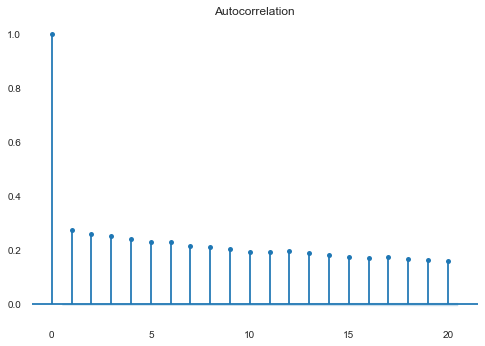

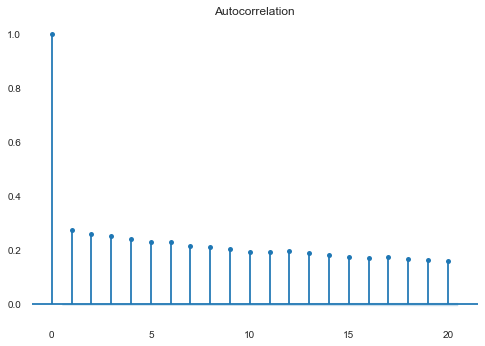

In [16]:
#plot the acf
plot_acf(df['Vacancy_Rate%'], lags=20, alpha=0.05)

In [19]:
#run augmented dickey-fuller test on Vacancy Rate data
results = adfuller(df['Vacancy_Rate%'])
print(results[1])

0.0


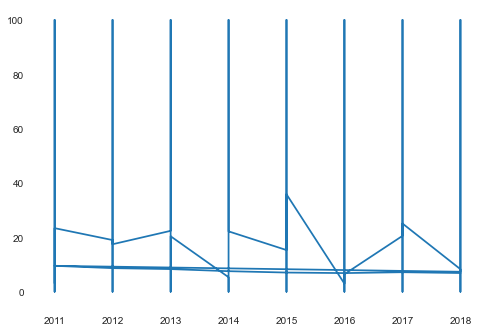

In [20]:
#plot vacacny rate
plt.plot(df['Vacancy_Rate%'])

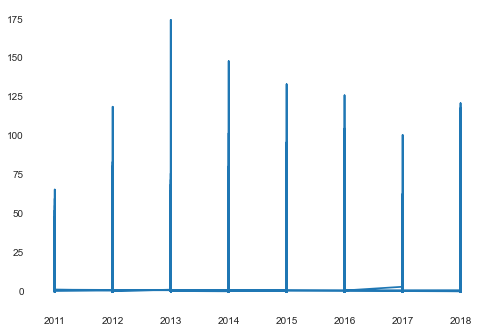

In [21]:
#plot vacancy rate change
plt.plot(df['Vacancy_Rate%_Change'])

In [23]:
#estimating an AR model
#esitmate parameters from data
mod = ARMA(df['Vacancy_Rate%'], order=(1, 0))
res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:          Vacancy_Rate%   No. Observations:               263002
Model:                     ARMA(1, 0)   Log Likelihood            -1098911.861
Method:                       css-mle   S.D. of innovations             15.790
Date:                Tue, 03 Nov 2020   AIC                        2197829.721
Time:                        10:34:12   BIC                        2197861.161
Sample:                             0   HQIC                       2197838.866
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  17.8069      0.043    418.809      0.000      17.724      17.890
ar.L1.Vacancy_Rate%     0.2758      0.002    147.165      0.000       0.272       0.280
                

In [ ]:
#forecasting an AR Model
res.plot_predict(start='2011-01-01', end='2018-01-01')
plt.show()

In [ ]:
#plot PACF
plot_pacf(df['Vacancy_Rate%'], lags=20, alpha=0.05)

In [ ]:
#define variable X, y
X = df.drop('Vacancy_Rate%', axis=1)
y = df['Vacancy_Rate%']

In [ ]:
#train test split for timeseries
tss = TimeSeriesSplit(n_splits = 8)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
#consider dropping MOE?

## Fit your models with a training dataset
Hint: Try a number of different models: you will want to compare their outputs in the
model evaluation stage. For example, if you’re writing a classification model, you should
implement both an entropy model and a Gini impurity model. For hyperparameter tuning,
think of methods like cross-validation .

In [ ]:
#time series doc... (USE 'STEPS FOR HOW TO ON A CASE STUDY...' as an overivew of what to do)
    '''
    1. plot data
    2. test for random walk
    3. take first difference
    4. compute acf and pacf
'''
    #simple linear regression (maybe skip b/c only one variable)
    #Autocorrelation & Autocorrelation Function
    #Random Walk (check if Random Walk) - don't think it is...
        #Stationarity, if needed
            #Look at 'Describe AR model' to see what kind of time series
            
    #ESTIMATING AND FORECASTING AN AR MODEL

## Review model outcomes — Iterate over additional models as needed 
Hint: you may want to use standard model evaluation metrics such as accuracy, recall,
precision, and F1.

In [ ]:
#time series doc (use datacamp course to get code)
    #choosing the right model
    #fit a few AR, MA and ARMA models..
    
    

## Identify the final model that you think is the best model for this project
Hint: the most powerful model isn’t always the best one to use. Other considerations
include computational complexity, scalability, and maintenance costs.


In [ ]:
#follow along with timeseries datacamp to do..
'''
    #use information criterioin to choose best model
    #forecast temperature over the next 2 years
    '''

## Reflection
Review the following questions and apply them to your analysis:
    
● Does my data involve a time series or forecasting? If so, am I splitting the train and test data appropriately?

● Is my response variable continuous or categorical? 